In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import yaml

# Import local packages
from examples.norm_norm_diffuse_1d import (
    prior_pdf,
    likelihood_pdf,
    posterior_pdf,
    plot_approximate_posterior,
    approximate_posterior_quantiles_against_x,
    plot_approximate_posterior_quantiles_against_x,
    plot_approximate_posterior_quantiles_diff_against_x,
    plot_approximate_posterior_hist
)
from sbc.sbc_tools import plot_sbc_all
results_path = "/Users/Lieve/Documents/Masters Project/SBC-SBI/results/toy_examples/norm_norm_diffuse_1d/npe_c/"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Define prior standard deviation
sigma = 150.

# Amortized NPE-C

In [3]:
amortized_posterior_ID = 0

# Load pre-trained amortized posterior
amortized_posterior_name = f"amortized_posterior{amortized_posterior_ID}"
path_to_amortized_posterior = results_path + amortized_posterior_name + ".pkl"
path_to_amortized_posterior_config = results_path + amortized_posterior_name + ".yaml"
path_to_amortized_posterior_simulations = results_path + amortized_posterior_name + "_simulations" + ".npz"

# Load posterior
with open(path_to_amortized_posterior, "rb") as f:
    amortized_posterior = pickle.load(f)

# Load config
with open(path_to_amortized_posterior_config, "r") as f:
    amortized_posterior_config = yaml.safe_load(f)

# Load samples
amortized_posterior_simulations = np.load(path_to_amortized_posterior_simulations)

print("Amortized posterior config:")
amortized_posterior_config


Amortized posterior config:


{'num_simulations': 20000,
 'sigma': 150.0,
 'simulation_time': 0.0005513750000001316,
 'total_time': 25.754204875,
 'training_time': 25.7536535}

In [4]:
# Turn DirectPosterior object into callable function
def approximate_posterior_amortized(theta, x):
    """
    Output analytical posterior approximation \hat{p}(theta | x)

    theta and x must be 1D torch tensors
    """
    return torch.exp(amortized_posterior.potential(theta, x))

Plot amortized posterior approximation for different $x_\text{observed}$.

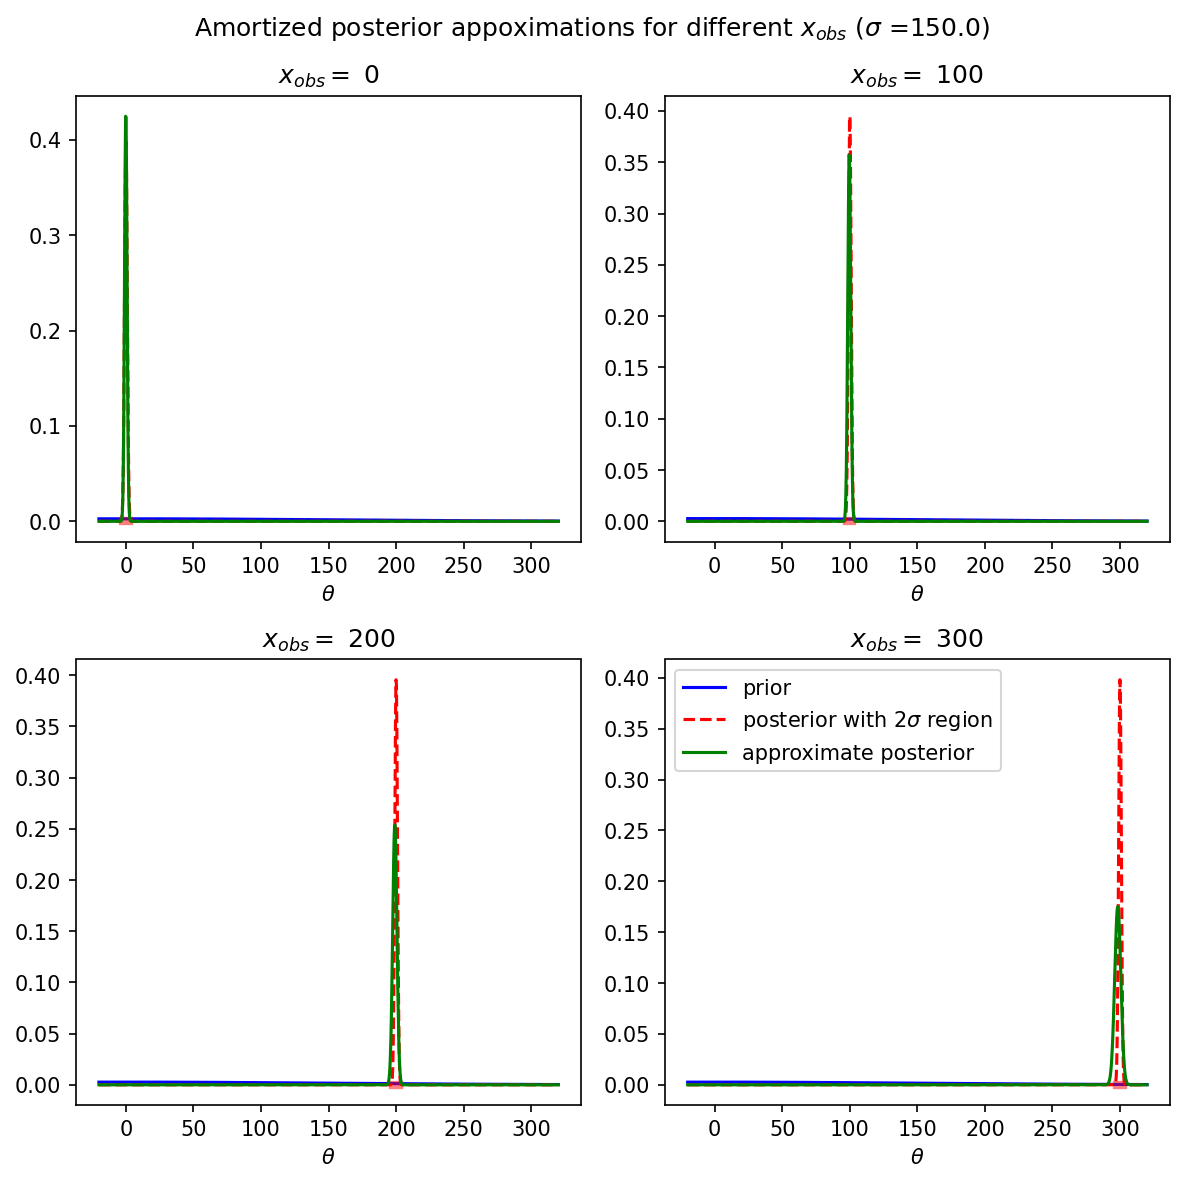

In [5]:
x_observed_values = [0, 100, 200, 300] # Range of observed data
theta_range = torch.linspace(-20,320, 1000).view(-1,1)
title = r"Amortized posterior appoximations for different $x_{obs}$ ($\sigma$ =" + f"{sigma})"
plot_approximate_posterior(approximate_posterior_amortized, prior_pdf, posterior_pdf, theta_range, x_observed_values, sigma, title=title)

Plot amortized posterior approximation for fixed $x_\text{observed}$.

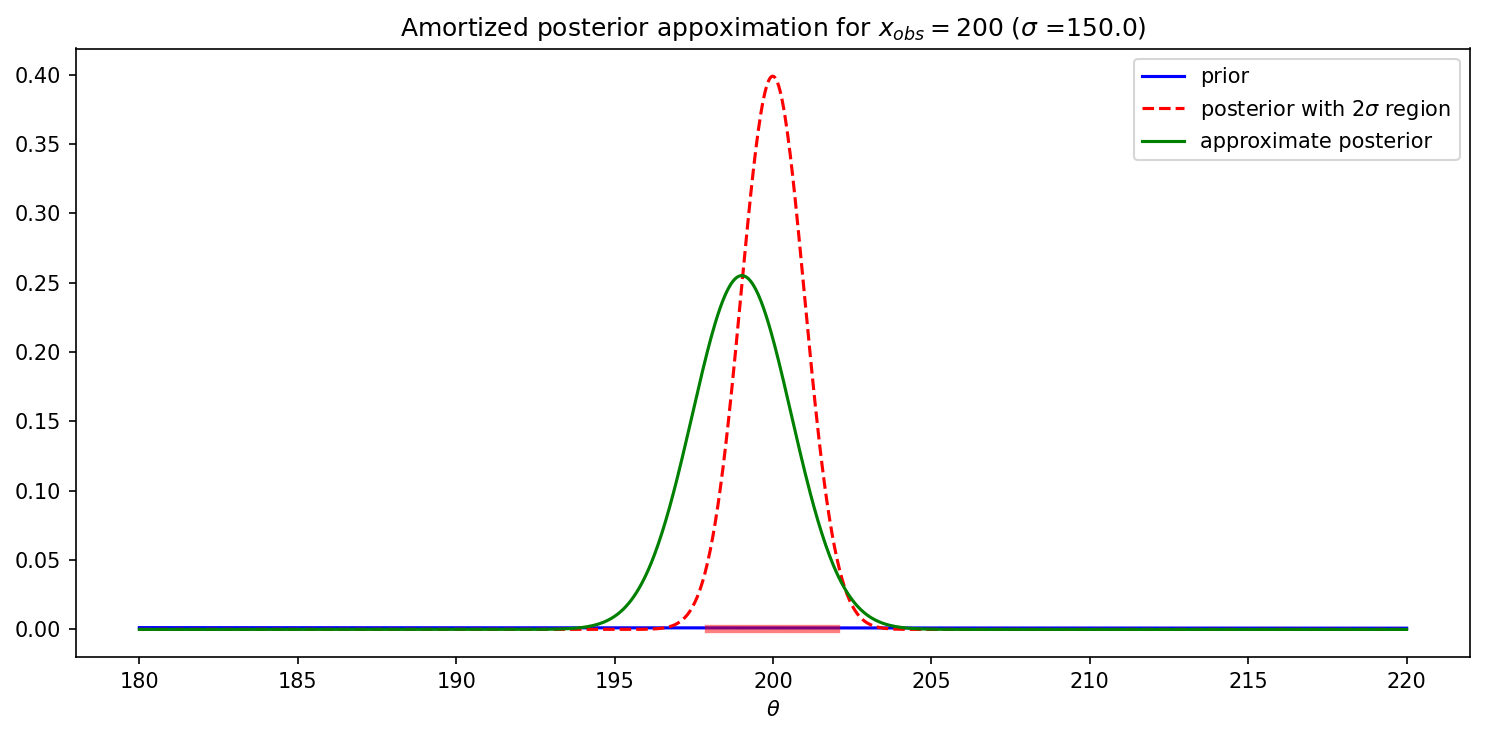

In [6]:
x_observed = 200 # Observed data
theta_range = torch.linspace(180,220,1000).view(-1,1)
title = r"Amortized posterior appoximation for $x_{obs} = $" +f"{x_observed} " + r"($\sigma$ =" + f"{sigma})"
plot_approximate_posterior(approximate_posterior_amortized, prior_pdf, posterior_pdf, theta_range, x_observed, sigma, title=title)

Plot quantiles of amortized posterior for various values of $x_\text{observed}$.

- Without the training samples

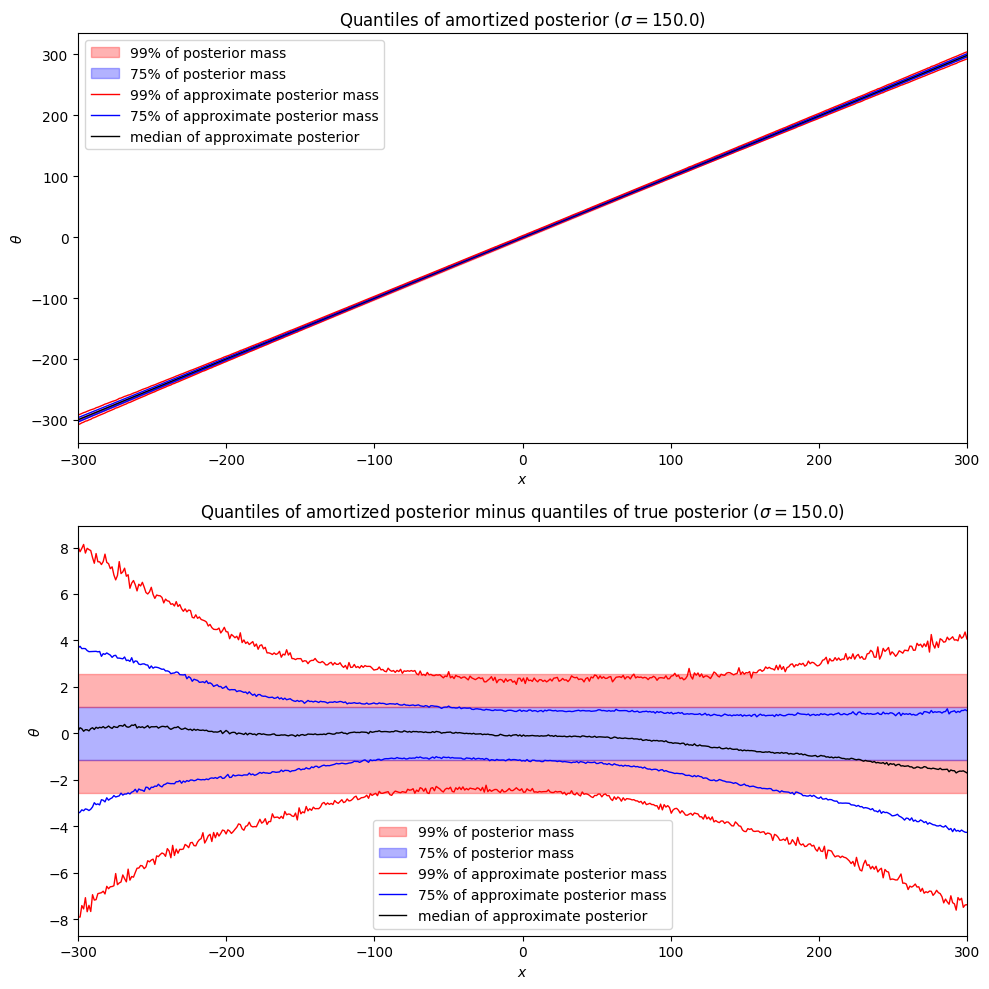

In [7]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(-300,300,500)
quantiles = approximate_posterior_quantiles_against_x(amortized_posterior, x_range)

title = "Quantiles of amortized posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, ax=ax[0])

title = "Quantiles of amortized posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax[1])

plt.tight_layout()
plt.show()

- With the training samples

In [8]:
# Retrieve samples
amortized_posterior_parameter_samples = amortized_posterior_simulations["parameter_samples"].reshape(-1)
amortized_posterior_data_samples = amortized_posterior_simulations["data_samples"].reshape(-1)
amortized_posterior_samples = {"parameter_samples": amortized_posterior_parameter_samples,
                                "data_samples": amortized_posterior_data_samples}

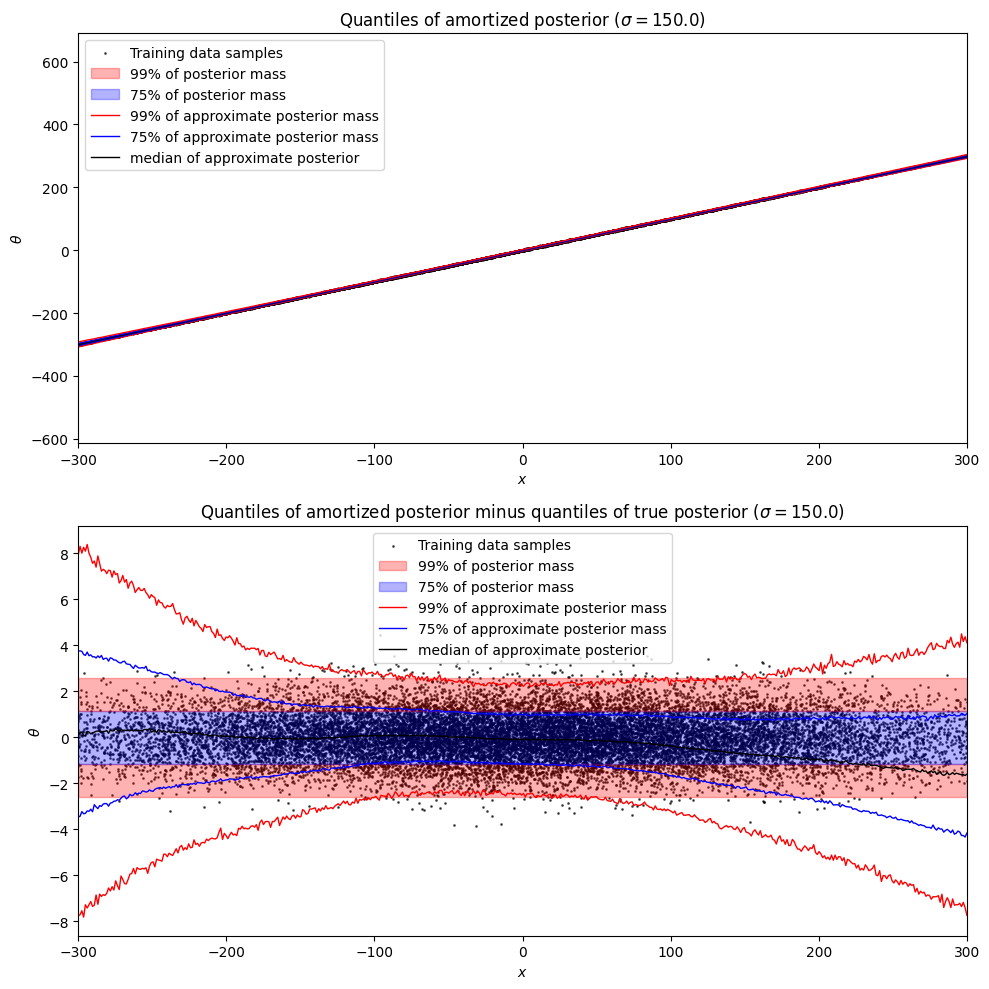

In [9]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(-300,300,500)
quantiles = approximate_posterior_quantiles_against_x(amortized_posterior, x_range)

title = "Quantiles of amortized posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, ax=ax[0], samples=amortized_posterior_samples)

title = "Quantiles of amortized posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax[1], samples=amortized_posterior_samples)

plt.tight_layout()
plt.show()

## SBC on amortized NPE-C

In [10]:
amortized_sbc_ID = 0

# Load pre-trained amortized sbc ranks
amortized_ranks_name = f"amortized_sbc_ranks{amortized_sbc_ID}_amortized_posterior{amortized_posterior_ID}"
path_to_amortized_ranks = results_path + amortized_ranks_name + ".npy"
path_to_amortized_ranks_config = results_path + amortized_ranks_name + ".yaml"
path_to_amortized_ranks_simulations = results_path + amortized_ranks_name + "_simulations" + ".npz"

# Load sbc ranks
amortized_ranks = np.load(path_to_amortized_ranks)

# Load config
with open(path_to_amortized_ranks_config, "r") as f:
    amortized_ranks_config = yaml.safe_load(f)

# Load samples
amortized_ranks_simulations = np.load(path_to_amortized_ranks_simulations)

N_iter = amortized_ranks_config["N_iter"]
N_samp = amortized_ranks_config["N_samp"]

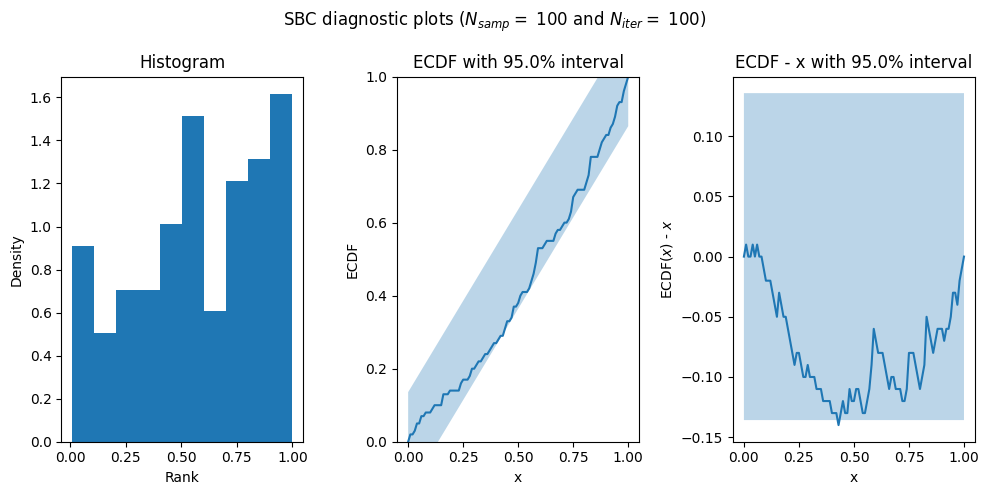

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [11]:
# Plot amortized ranks
plot_sbc_all(ranks=amortized_ranks, N_samp=N_samp)

# Sequential NPE-C (SNPE-C)

Tutorial can be found here: https://sbi.readthedocs.io/en/latest/how_to_guide/02_multiround_inference.html

In [12]:
sequential_posterior_ID = 0

# Load pre-trained posterior
sequential_posterior_name = f"sequential_posterior{sequential_posterior_ID}"
path_to_sequential_posterior = results_path + sequential_posterior_name + ".pkl"
path_to_sequential_posterior_config = results_path + sequential_posterior_name + ".yaml"
path_to_sequential_posterior_simulations = results_path + sequential_posterior_name + "_simulations" + ".npz"

# Load posterior
with open(path_to_sequential_posterior, "rb") as f:
    sequential_posterior = pickle.load(f)

# Load config
with open(path_to_sequential_posterior_config, "r") as f:
    sequential_posterior_config = yaml.safe_load(f)

# Load samples
sequential_posterior_simulations = np.load(path_to_sequential_posterior_simulations)

print("Sequential posterior config:")
sequential_posterior_config

Sequential posterior config:


{'num_sequential_rounds': 4,
 'num_simulations_per_round': 5000,
 'sigma': 150.0,
 'simulation_times': [0.0010179169999999793,
  0.03446112499999998,
  0.012143334000001005,
  0.01079241699999045],
 'total_time': 30.222365250999992,
 'training_times': [30.163950458000002],
 'x_observed': 200.0}

A bug in the `sbi` package means that we cannot obtain the exact functional form of the sequential posterior. Thus, we must visualize it by generating samples and plotting a histogram.

Below we plot the sequential posterior approximation for different $x$.

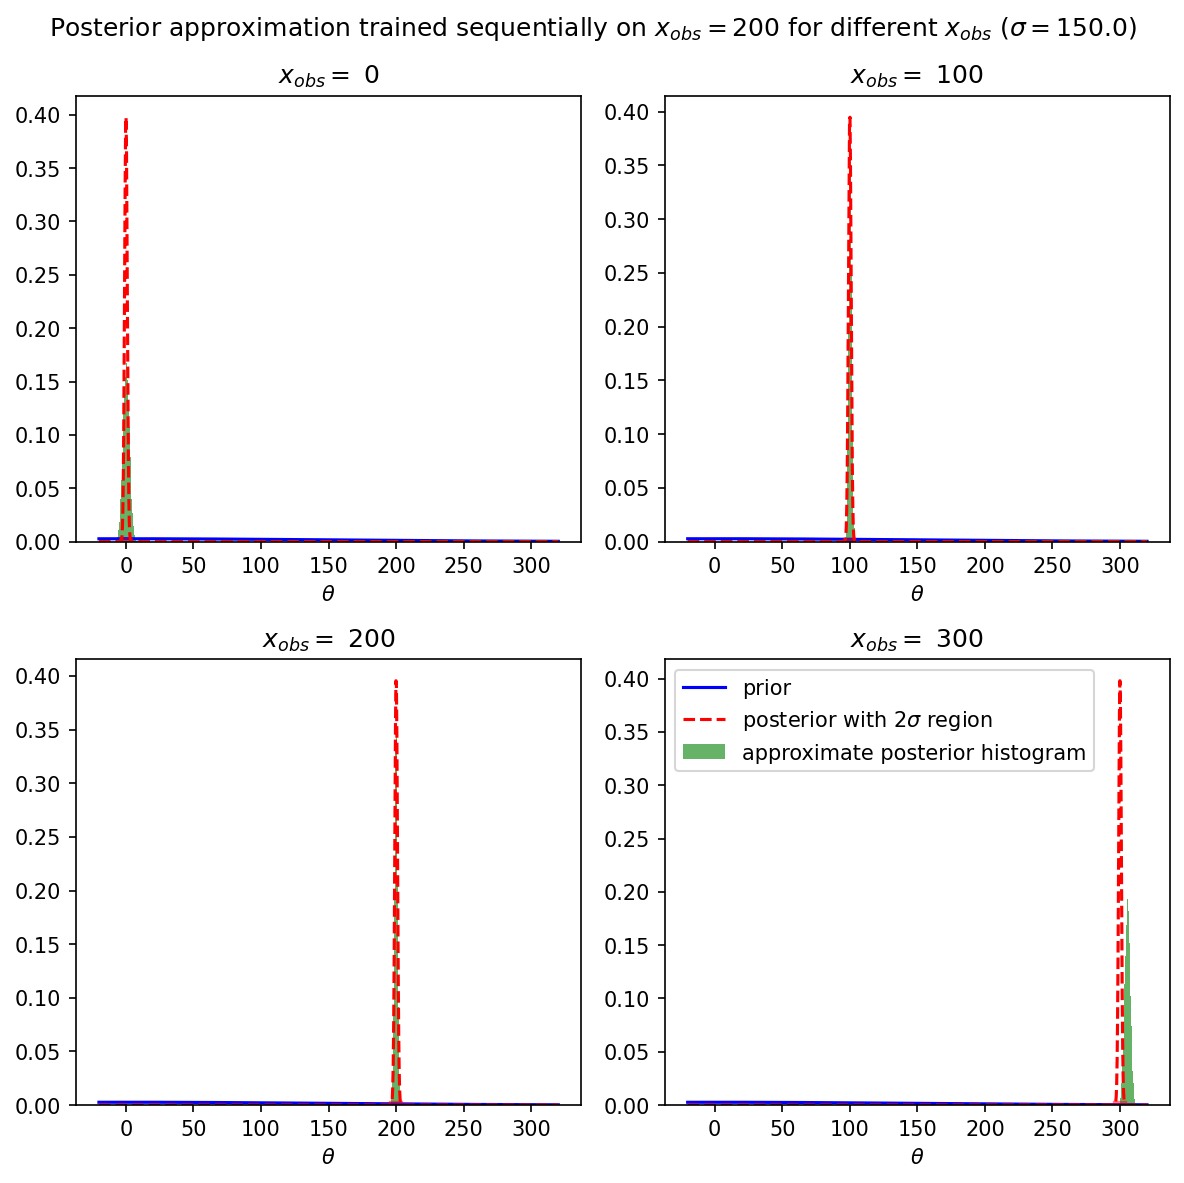

In [13]:
sequential_posterior_samples_x_observed_values = []
for x in x_observed_values:
    sequential_posterior_samples_x_observed_values.append(sequential_posterior.sample((10000, ), x=x, show_progress_bars=False))

theta_range = torch.linspace(-20,320, 1000).view(-1,1)
title=r"Posterior approximation trained sequentially on $x_{obs} = $" + f"{x_observed} for different " + r"$x_{obs}$" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_hist(sequential_posterior_samples_x_observed_values, prior_pdf, posterior_pdf, theta_range, x_observed=x_observed_values, sigma=sigma, title=title)

Plot the sequential posterior approximation at $x_\text{observed}$.

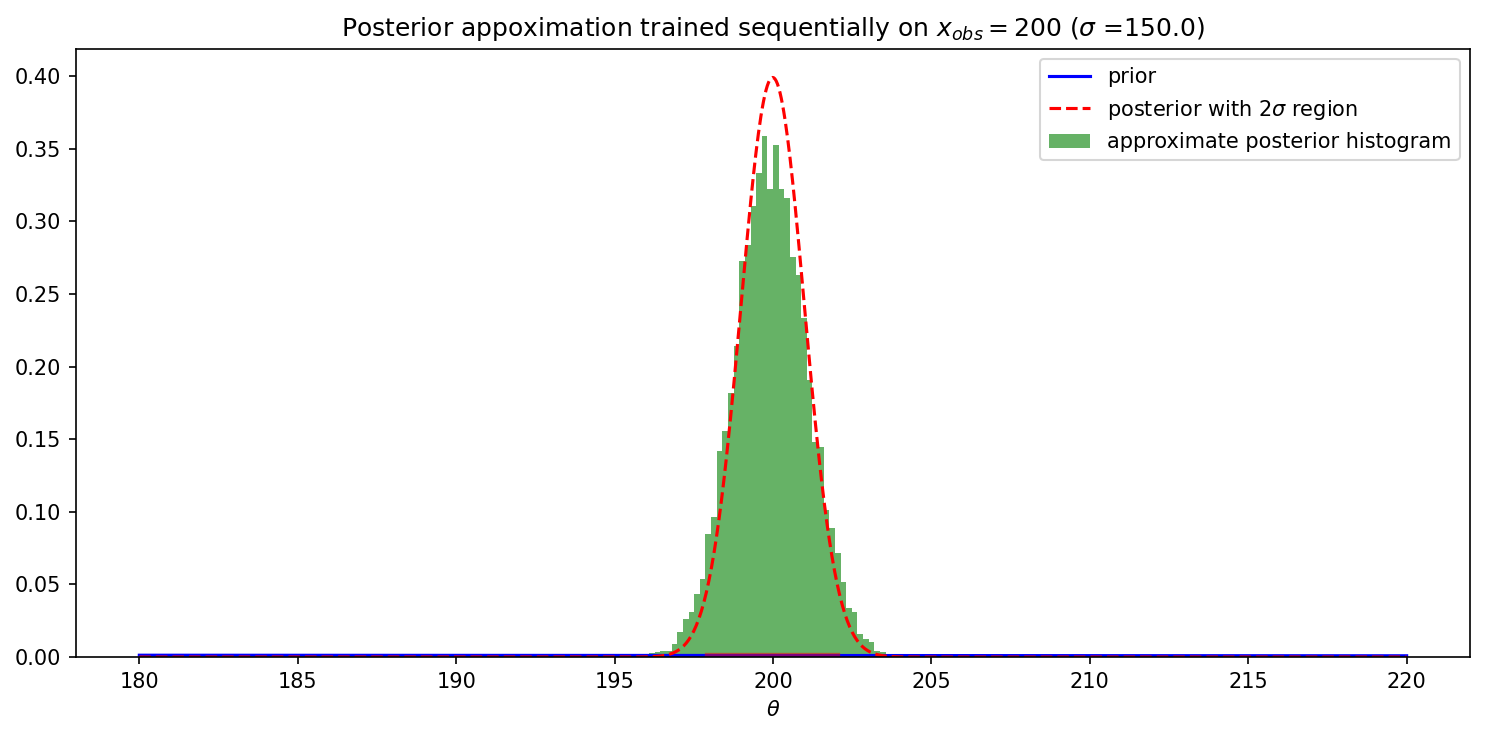

In [14]:
sequential_posterior_samples_x_observed = sequential_posterior.sample((10000, ), x=x_observed, show_progress_bars=False).view(-1).tolist()
theta_range = torch.linspace(180,220,1000).view(-1,1)
title = r"Posterior appoximation trained sequentially on $x_{obs} = $" +f"{x_observed} " + r"($\sigma$ =" + f"{sigma})"
plot_approximate_posterior_hist(sequential_posterior_samples_x_observed, prior_pdf, posterior_pdf, theta_range, x_observed, sigma, title=title)

Plot quantiles of sequential posterior for various values of $x$.

- Without training samples

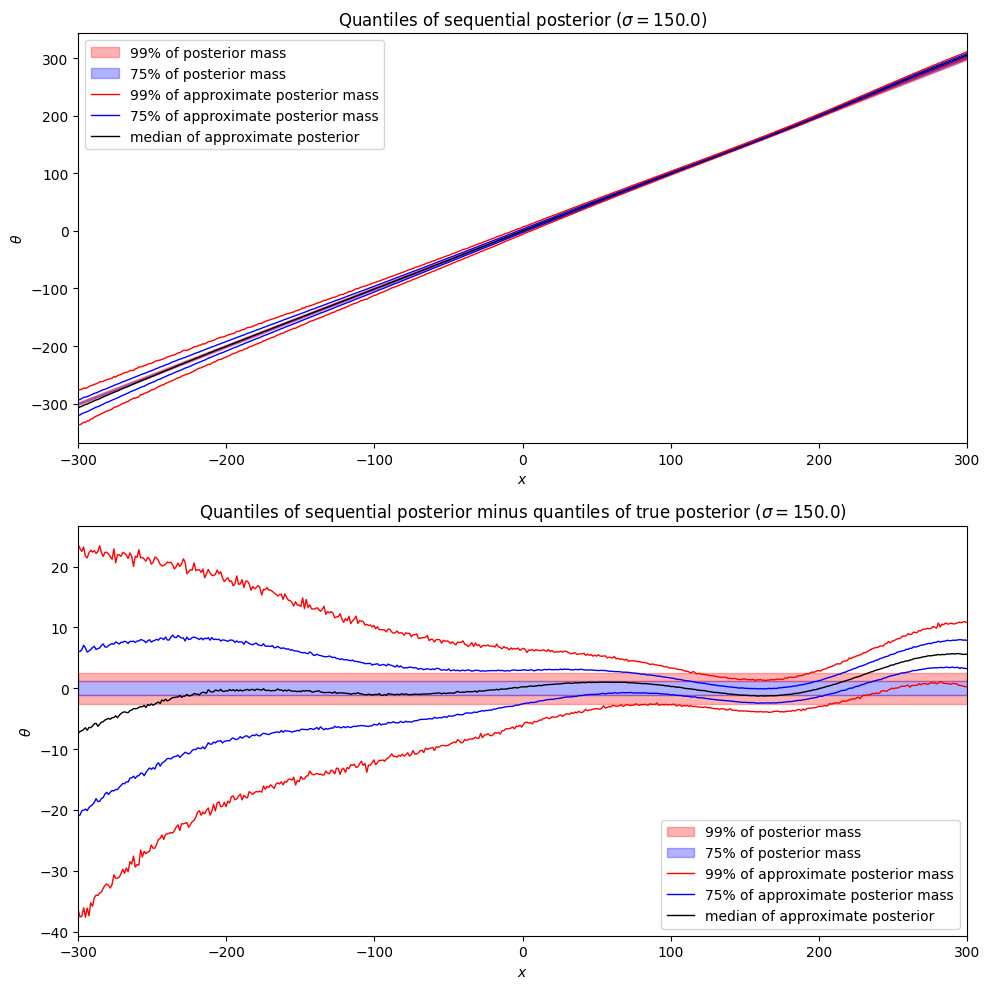

In [15]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(-300,300,500)
quantiles = approximate_posterior_quantiles_against_x(sequential_posterior, x_range)

title = "Quantiles of sequential posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, ax=ax[0])

title = "Quantiles of sequential posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax[1])

plt.tight_layout()
plt.show()

- With training samples

In [ ]:
# Retrieve samples
num_sequential_rounds = sequential_posterior_config["num_sequential_rounds"]
parameter_samples_per_round = []
data_samples_per_round = []
for r in range(num_sequential_rounds):
    parameter_samples_per_round.append(sequential_posterior_simulations[f"parameter_samples_round_{r}"].reshape(-1))
    data_samples_per_round.append(sequential_posterior_simulations[f"data_samples_round_{r}"].reshape(-1))

sequential_posterior_samples = {"parameter_samples": parameter_samples_per_round,
                                "data_samples": data_samples_per_round}

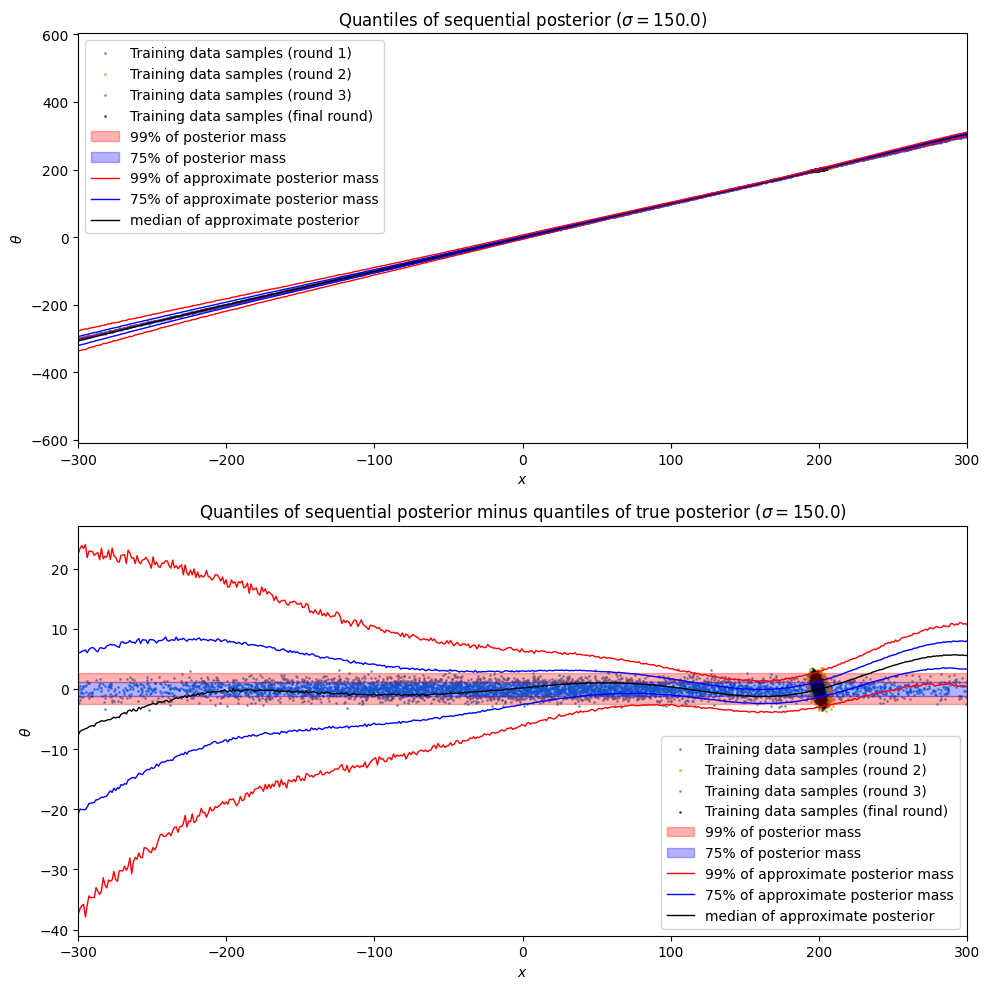

In [17]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)

x_range = np.linspace(-300,300,500)
quantiles = approximate_posterior_quantiles_against_x(sequential_posterior, x_range)

title = "Quantiles of sequential posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, ax=ax[0], samples=sequential_posterior_samples)

title = "Quantiles of sequential posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax[1], samples=sequential_posterior_samples)

plt.tight_layout()
plt.show()

- With training samples, and zoomed in on $x_\text{observed}$

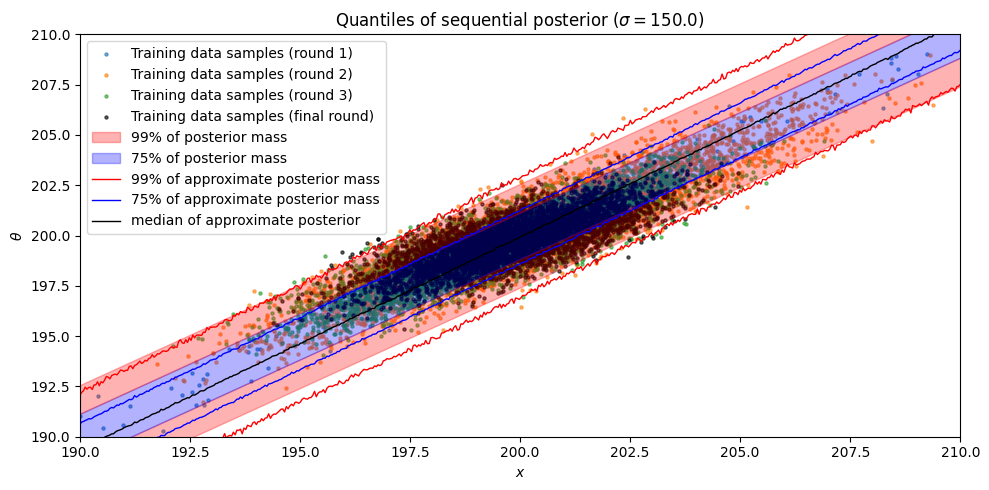

In [33]:
fig, ax = plt.subplots(figsize=(10,5))

x_range = np.linspace(190,210,500)
quantiles = approximate_posterior_quantiles_against_x(sequential_posterior, x_range)

title = "Quantiles of sequential posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_against_x(x_range, quantiles, sigma, title=title, samples=sequential_posterior_samples, ax=ax,s=5)
ax.set_ylim((min(x_range), max(x_range)))

plt.tight_layout()
plt.show()

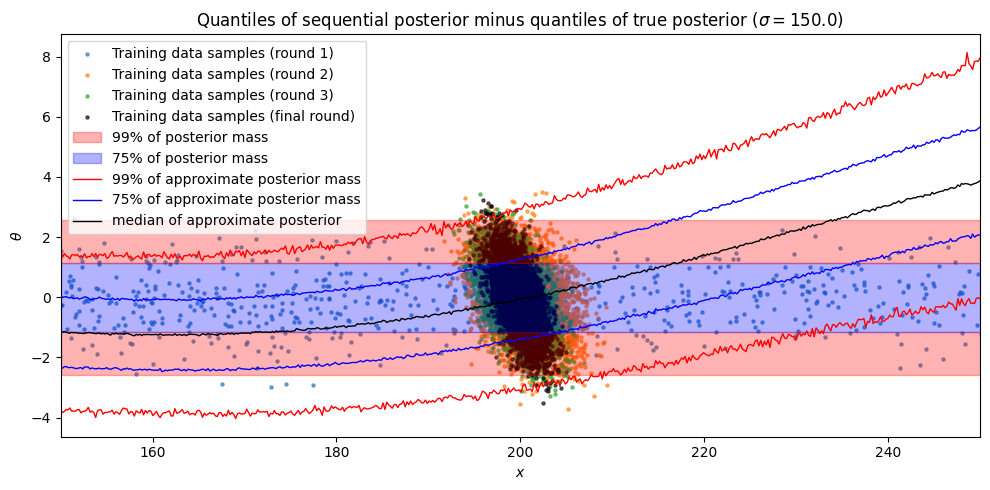

In [31]:
fig, ax = plt.subplots(figsize=(10,5))

x_range = np.linspace(150,250,500)
quantiles = approximate_posterior_quantiles_against_x(sequential_posterior, x_range)

title = "Quantiles of sequential posterior minus quantiles of true posterior" + r" ($\sigma = $" + f"{sigma})"
plot_approximate_posterior_quantiles_diff_against_x(x_range, quantiles, sigma, title=title, ax=ax, samples=sequential_posterior_samples, s=5)

plt.tight_layout()
plt.show()

## SBC on SNPE-C

In [18]:
sequential_sbc_ID = 0

# Load pre-trained sbc ranks
sequential_ranks_name = f"sequential_sbc_ranks{sequential_sbc_ID}"
path_to_sequential_ranks = results_path + sequential_ranks_name + ".npy"
path_to_sequential_ranks_config = results_path + sequential_ranks_name + ".yaml"
path_to_sequential_ranks_simulations = results_path + sequential_ranks_name + "_simulations" + ".npz"

# Load sbc ranks
sequential_ranks = np.load(path_to_sequential_ranks)

# Load config
with open(path_to_sequential_ranks_config, "r") as f:
    sequential_ranks_config = yaml.safe_load(f)

# Load samples
amortized_ranks_simulations = np.load(path_to_amortized_ranks_simulations)

N_iter = sequential_ranks_config["N_iter"]
N_samp = sequential_ranks_config["N_samp"]

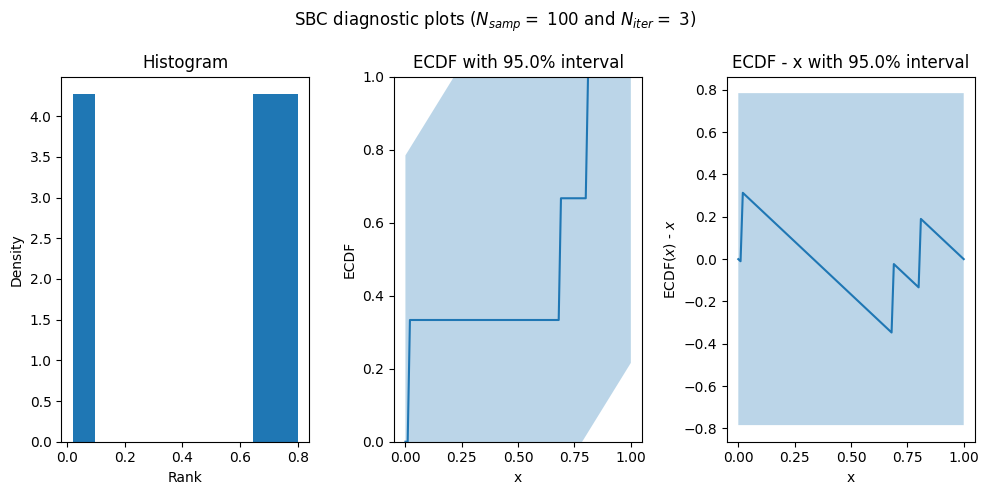

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [19]:
plot_sbc_all(ranks=sequential_ranks, N_samp=N_samp)